In [1]:
%matplotlib inline
%load_ext autotime

import math
import matplotlib as mpl
import matplotlib.pyplot as pt
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics

In [2]:
import keras
import tensorflow as tf

Using TensorFlow backend.


time: 9.74 s


In [3]:
mpl.rcParams[ 'figure.figsize' ] = ( 18, 3 )

time: 893 µs


# load data

In [4]:
from keras.datasets import mnist
( train_x, train_y ), ( test_x, test_y ) = mnist.load_data()
train_x = train_x.astype( float ).reshape( train_x.shape[ 0 ], -1 )
train_x = sk.preprocessing.StandardScaler().fit_transform( train_x )
train_y = keras.utils.to_categorical( train_y )
test_x = test_x.astype( float ).reshape( test_x.shape[ 0 ], -1 )
test_x = sk.preprocessing.StandardScaler().fit_transform( test_x )
test_y = keras.utils.to_categorical( test_y )
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

time: 1.07 s


# parameters

In [5]:
hidden_dim = 512
n_layers = 100
batch_size = 10000
epochs = 100

time: 1.16 ms


# self normalizing neural network

In [6]:
def selu( x ):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * tf.where( x > 0., x, alpha * tf.nn.elu( x ) )

time: 72.6 ms


In [7]:
def init( shape, dtype=None ):
    return tf.random_normal( shape, stddev=tf.sqrt( 1. / shape[ 1 ] ) )

time: 57.8 ms


In [8]:
ms1 = []
ms1.append( keras.models.Sequential() )
ms1[ 0 ].add( keras.layers.Dense( hidden_dim, input_shape=train_x.shape[ 1: ], kernel_initializer=init ) )
ms1[ 0 ].add( keras.layers.Activation( selu ) )
for i in range( n_layers ):
    ms1.append( keras.models.Sequential() )
    ms1[ i + 1 ].add( keras.layers.Dense( hidden_dim, input_shape=( hidden_dim, ), kernel_initializer=init ) )
    ms1[ i + 1 ].add( keras.layers.Activation( selu ) )

time: 916 ms


The following optimizers cannot lead to zero mean and unit variance
- SGD with momentum (without Nesterov) 
- RMSprop
- Adam

In [9]:
m1 = keras.models.Sequential()
for i in ms1:
    m1.add( i )
m1.add( keras.layers.Dense( train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m1.add( keras.layers.Activation( 'softmax' ) )
# m1.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=[ 'acc' ] )
m1.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(), metrics=[ 'acc' ] )

time: 444 ms


In [10]:
h1 = m1.fit( train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=0 )

time: 3min 54s


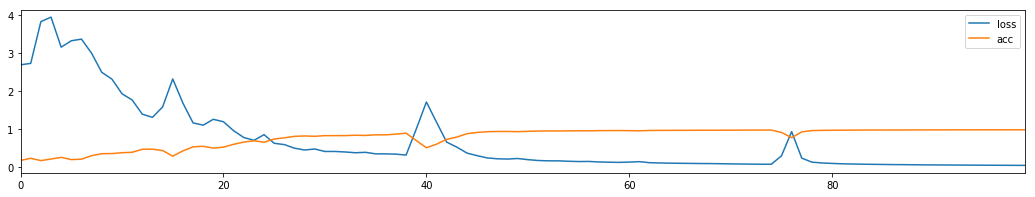

time: 143 ms


In [11]:
_ = pd.Series( h1.history[ 'loss' ], name='loss' ).plot.line( legend=True )
_ = pd.Series( h1.history[ 'acc' ], name='acc' ).plot.line( legend=True )

In [12]:
sk.metrics.accuracy_score( np.argmax( train_y, 1 ), np.argmax( m1.predict( train_x, batch_size=batch_size ), 1 ) )

0.98946666666666672

time: 1.2 s


In [13]:
ps = []
p = train_x
ps.append( tuple( ( p.mean(), p.var() ) ) )
for i in range( len( ms1 ) ):
    p = ms1[ i ].predict( p, batch_size=batch_size )
    ps.append( tuple( ( p.mean(), p.var() ) ) )

time: 31.6 s


In [14]:
print( 'layer\tmean\tvar' )
for i, p in enumerate( ps ):
    print( '%r\t%r\t%r' % ( i, p[ 0 ], p[ 1 ] ) )

layer	mean	var
0	-2.1974863349995617e-18	0.91454081632655582
1	0.023476582	1.2228079
2	0.019054014	1.129766
3	0.013584105	1.0925844
4	0.012024267	1.0915987
5	0.010935271	1.0952393
6	0.009069846	1.1127968
7	0.013852996	1.1459919
8	0.019398749	1.1769044
9	0.027005866	1.2014954
10	0.020433107	1.2097999
11	0.024373205	1.2221954
12	0.026944164	1.2359024
13	0.032068234	1.2465514
14	0.025314556	1.2571433
15	0.025994008	1.2565379
16	0.037361927	1.2829134
17	0.037144538	1.3070035
18	0.0374857	1.3060539
19	0.038895652	1.3270507
20	0.050693508	1.3486868
21	0.033020139	1.3382198
22	0.034056954	1.3421797
23	0.034748644	1.3207383
24	0.031895339	1.3232962
25	0.030703427	1.3462083
26	0.030176301	1.338685
27	0.050288975	1.3599203
28	0.035149787	1.4053568
29	0.054691564	1.4193536
30	0.0469134	1.4555081
31	0.044842627	1.4423159
32	0.034465007	1.4117254
33	0.048313472	1.4491298
34	0.056843176	1.4677677
35	0.048341598	1.4758517
36	0.058841787	1.5092973
37	0.056223869	1.5485386
38	0.045042798	1.5392503
39	0

layer # 0
mean: -7.87577e-06
var: 0.00194875


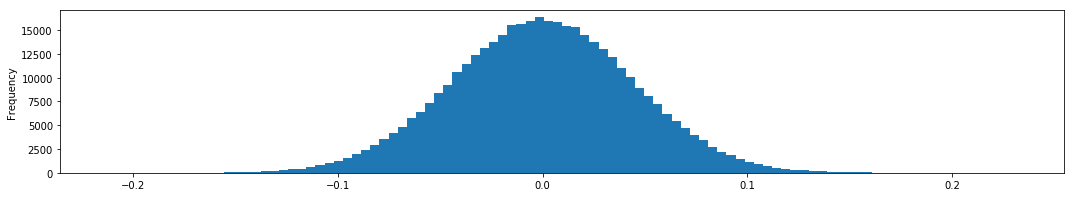

time: 2.71 s


In [15]:
n = 0
t = [ weights.flatten() for layer in ms1[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 33
mean: 6.33635e-05
var: 0.00196178


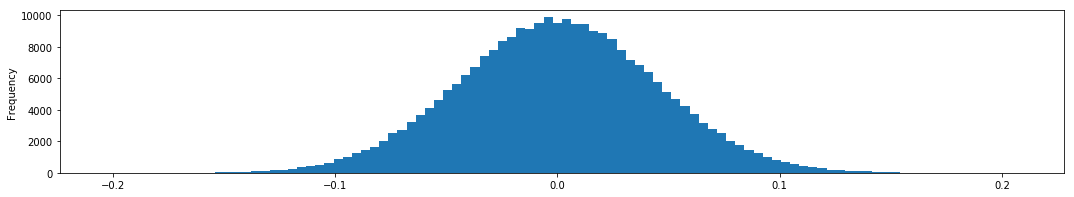

time: 2.03 s


In [16]:
n = len( ms1 ) // 3
t = [ weights.flatten() for layer in ms1[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 66
mean: 3.13185e-05
var: 0.00194715


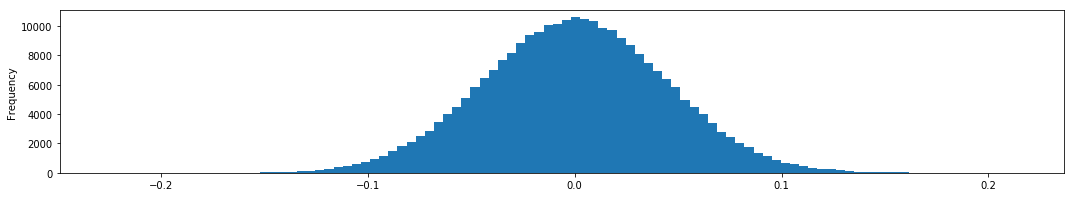

time: 1.89 s


In [17]:
n = len( ms1 ) // 3 * 2
t = [ weights.flatten() for layer in ms1[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 100
mean: -0.000184787
var: 0.00195404


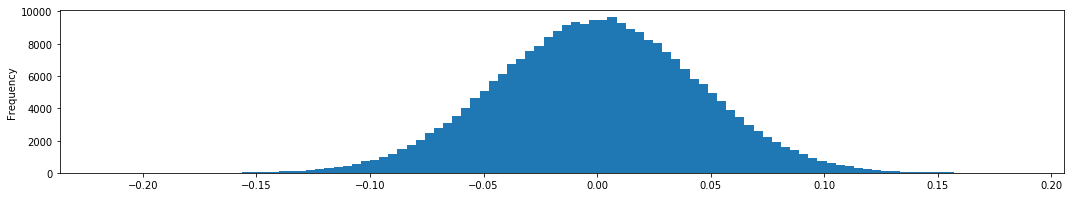

time: 1.9 s


In [18]:
n = len( ms1 ) - 1
t = [ weights.flatten() for layer in ms1[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

# batch normalization

In [19]:
ms2 = []
ms2.append( keras.models.Sequential() )
ms2[ 0 ].add( keras.layers.Dense( hidden_dim, input_shape=train_x.shape[ 1: ], kernel_initializer=init ) )
ms2[ 0 ].add( keras.layers.BatchNormalization() )
ms2[ 0 ].add( keras.layers.advanced_activations.ELU() )
for i in range( n_layers ):
    ms2.append( keras.models.Sequential() )
    ms2[ i + 1 ].add( keras.layers.Dense( hidden_dim, input_shape=( hidden_dim, ), kernel_initializer=init ) )
    ms2[ i + 1 ].add( keras.layers.BatchNormalization() )
    ms2[ i + 1 ].add( keras.layers.advanced_activations.ELU() )

time: 3.1 s


In [20]:
m2 = keras.models.Sequential()
for i in ms2:
    m2.add( i )
m2.add( keras.layers.Dense( train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m2.add( keras.layers.Activation( 'softmax' ) )
m2.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=[ 'acc' ] )

time: 2.02 s


In [21]:
h2 = m2.fit( train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=0 )

time: 5min 14s


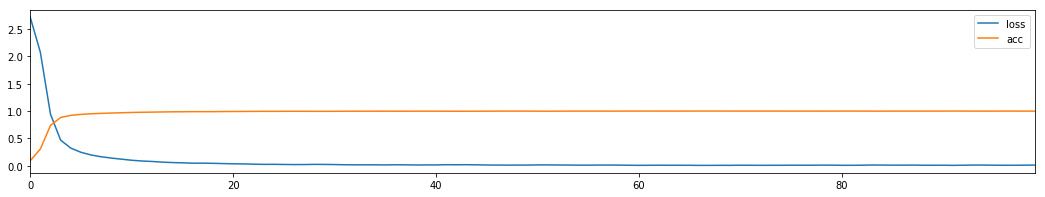

time: 144 ms


In [22]:
_ = pd.Series( h2.history[ 'loss' ], name='loss' ).plot.line( legend=True )
_ = pd.Series( h2.history[ 'acc' ], name='acc' ).plot.line( legend=True )

In [23]:
sk.metrics.accuracy_score( np.argmax( train_y, 1 ), np.argmax( m2.predict( train_x, batch_size=batch_size ), 1 ) )

0.99504999999999999

time: 2.47 s


In [24]:
ps = []
p = train_x
ps.append( tuple( ( p.mean(), p.var() ) ) )
for i in range( len( ms2 ) ):
    p = ms2[ i ].predict( p, batch_size=batch_size )
    ps.append( tuple( ( p.mean(), p.var() ) ) )

time: 2min 2s


In [25]:
print( 'layer\tmean\tvar' )
for i, p in enumerate( ps ):
    print( '%r\t%r\t%r' % ( i, p[ 0 ], p[ 1 ] ) )

layer	mean	var
0	-2.1974863349995617e-18	0.91454081632655582
1	0.14176093	0.60378224
2	0.14946979	0.62553996
3	0.15639715	0.63068134
4	0.15900914	0.64195526
5	0.1622124	0.64955586
6	0.16304617	0.65381628
7	0.16461478	0.66038716
8	0.16815245	0.66768199
9	0.16994812	0.67924064
10	0.17125975	0.68290591
11	0.1698968	0.68913531
12	0.17257494	0.69774377
13	0.17718284	0.70818418
14	0.17648934	0.71669477
15	0.17850083	0.73176938
16	0.18170515	0.7357102
17	0.17978446	0.73695457
18	0.17973679	0.74171233
19	0.1789981	0.74331361
20	0.18227679	0.74533874
21	0.18191612	0.74289888
22	0.18038763	0.74927735
23	0.18176262	0.75781769
24	0.18096116	0.75948423
25	0.18136705	0.76514077
26	0.18155292	0.75964576
27	0.17498021	0.75943905
28	0.18065502	0.76153904
29	0.17667042	0.76425678
30	0.18083683	0.76273322
31	0.17907797	0.76619685
32	0.18004169	0.76643842
33	0.1786541	0.77235705
34	0.17608561	0.77450168
35	0.17727575	0.76720583
36	0.17800592	0.75663644
37	0.17116821	0.76755375
38	0.17506996	0.76337278
39	

layer # 0
mean: -0.000285661
var: 0.00200666


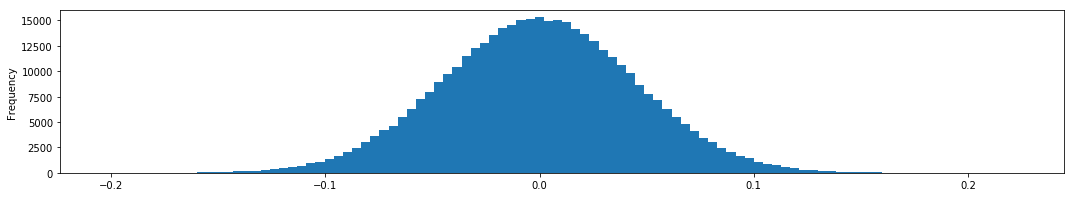

time: 2.95 s


In [26]:
n = 0
t = [ weights.flatten() for layer in ms2[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 33
mean: -4.964e-06
var: 0.00198737


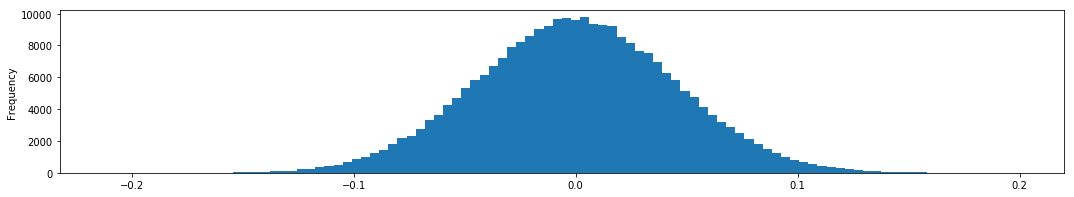

time: 2.07 s


In [27]:
n = len( ms2 ) // 3
t = [ weights.flatten() for layer in ms2[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 66
mean: 8.63828e-06
var: 0.00199061


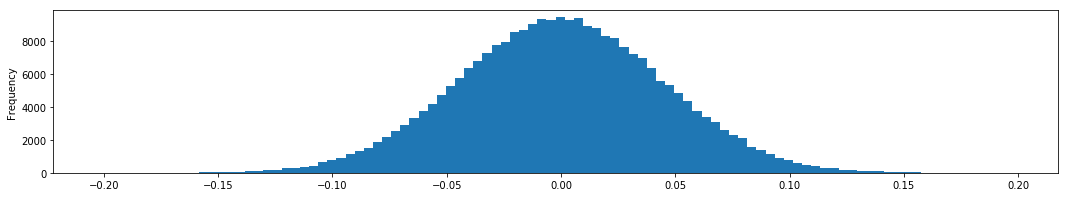

time: 2.08 s


In [28]:
n = len( ms2 ) // 3 * 2
t = [ weights.flatten() for layer in ms2[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 100
mean: 0.000107908
var: 0.00197802


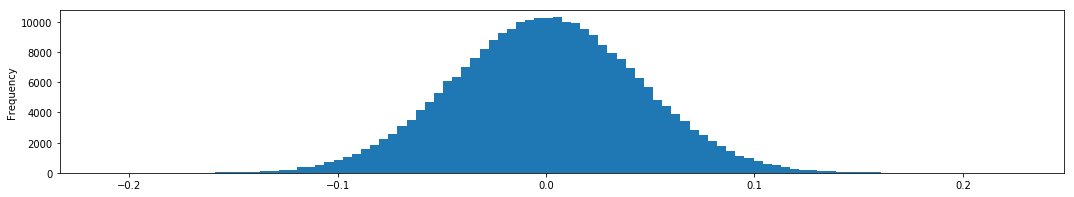

time: 2.01 s


In [29]:
n = len( ms2 ) - 1
t = [ weights.flatten() for layer in ms2[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

# elu only

In [30]:
ms3 = []
ms3.append( keras.models.Sequential() )
ms3[ 0 ].add( keras.layers.Dense( hidden_dim, input_shape=train_x.shape[ 1: ], kernel_initializer=init ) )
ms3[ 0 ].add( keras.layers.BatchNormalization() )
ms3[ 0 ].add( keras.layers.advanced_activations.ELU() )
for i in range( n_layers ):
    ms3.append( keras.models.Sequential() )
    ms3[ i + 1 ].add( keras.layers.Dense( hidden_dim, input_shape=( hidden_dim, ), kernel_initializer=init ) )
    ms3[ i + 1 ].add( keras.layers.BatchNormalization() )
    ms3[ i + 1 ].add( keras.layers.advanced_activations.ELU() )

time: 3.36 s


In [31]:
m3 = keras.models.Sequential()
for i in ms3:
    m3.add( i )
m3.add( keras.layers.Dense( train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m3.add( keras.layers.Activation( 'softmax' ) )
m3.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=[ 'acc' ] )

time: 1.84 s


In [32]:
h3 = m3.fit( train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=0 )

time: 5min 15s


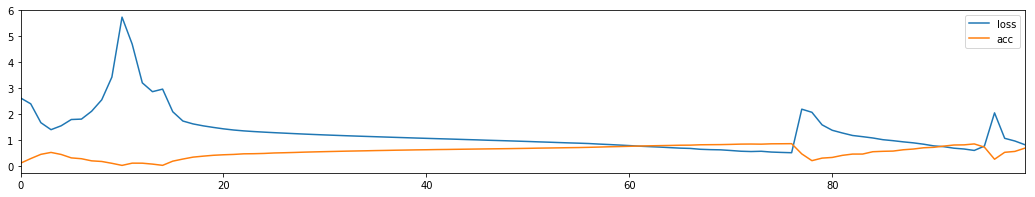

time: 144 ms


In [33]:
_ = pd.Series( h3.history[ 'loss' ], name='loss' ).plot.line( legend=True )
_ = pd.Series( h3.history[ 'acc' ], name='acc' ).plot.line( legend=True )

In [34]:
sk.metrics.accuracy_score( np.argmax( train_y, 1 ), np.argmax( m3.predict( train_x, batch_size=batch_size ), 1 ) )

0.62744999999999995

time: 3.42 s


In [35]:
ps = []
p = train_x
ps.append( tuple( ( p.mean(), p.var() ) ) )
for i in range( len( ms3 ) ):
    p = ms3[ i ].predict( p, batch_size=batch_size )
    ps.append( tuple( ( p.mean(), p.var() ) ) )

time: 3min 37s


In [36]:
print( 'layer\tmean\tvar' )
for i, p in enumerate( ps ):
    print( '%r\t%r\t%r' % ( i, p[ 0 ], p[ 1 ] ) )

layer	mean	var
0	-2.1974863349995617e-18	0.91454081632655582
1	0.11472291	0.642712
2	0.12966467	0.60034972
3	0.12333624	0.54339719
4	0.12331277	0.50840497
5	0.13027209	0.51686919
6	0.14188716	0.53554237
7	0.14695179	0.55512798
8	0.15524963	0.5752418
9	0.16020913	0.59588438
10	0.16671045	0.61456984
11	0.17260545	0.63142997
12	0.17355923	0.63913804
13	0.17750949	0.65166879
14	0.1751155	0.65738541
15	0.17845887	0.66402537
16	0.18280393	0.67376512
17	0.18026239	0.67790252
18	0.18555738	0.68130726
19	0.18332005	0.68340451
20	0.18743977	0.68906838
21	0.18682267	0.69020277
22	0.18905264	0.69683307
23	0.18845704	0.69919342
24	0.1869515	0.69978869
25	0.1889832	0.70265019
26	0.19119258	0.70685673
27	0.19004799	0.70879596
28	0.19175602	0.70327997
29	0.1904324	0.70561582
30	0.19257031	0.70818973
31	0.18997848	0.71715033
32	0.19299139	0.71860564
33	0.19760655	0.72201514
34	0.19657406	0.72066385
35	0.19030486	0.71554029
36	0.19185163	0.711272
37	0.19165812	0.70541608
38	0.18896842	0.69984609
39	0.18

layer # 0
mean: 0.000433723
var: 0.00212781


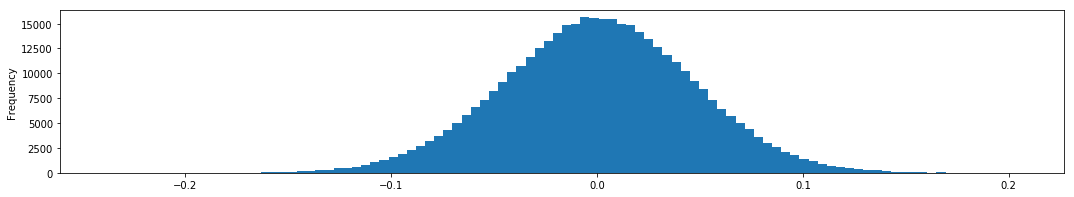

time: 3.15 s


In [37]:
n = 0
t = [ weights.flatten() for layer in ms3[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 33
mean: 9.01701e-05
var: 0.00228148


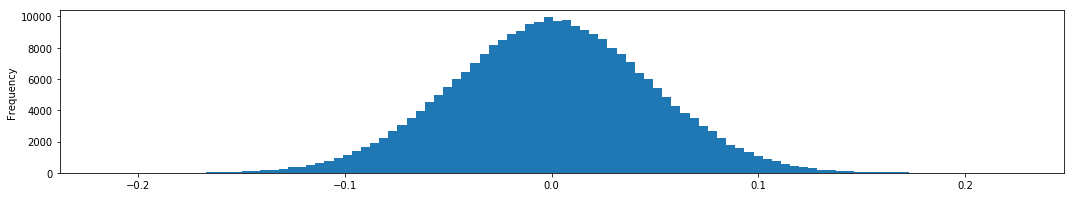

time: 2.26 s


In [38]:
n = len( ms3 ) // 3
t = [ weights.flatten() for layer in ms3[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 66
mean: 0.00038108
var: 0.00234986


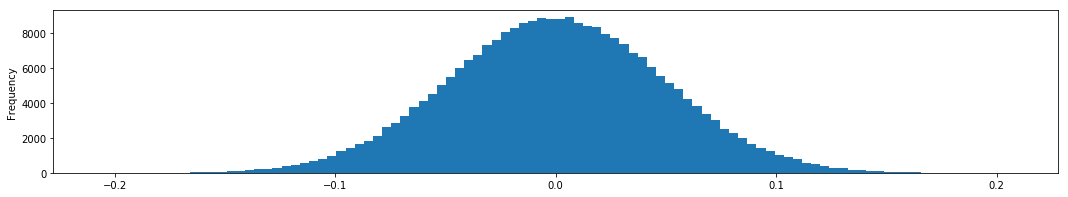

time: 2.26 s


In [39]:
n = len( ms3 ) // 3 * 2
t = [ weights.flatten() for layer in ms3[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 100
mean: 3.68527e-05
var: 0.00230261


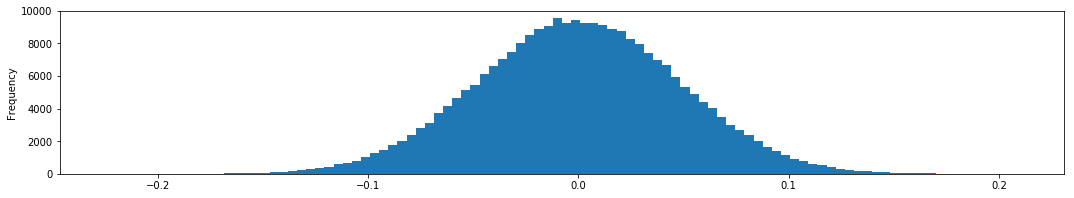

time: 2.27 s


In [40]:
n = len( ms3 ) - 1
t = [ weights.flatten() for layer in ms3[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

# compare

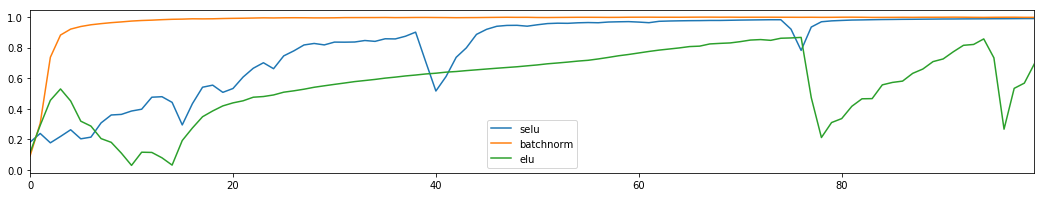

time: 167 ms


In [41]:
_ = pd.Series( h1.history[ 'acc' ], name='selu' ).plot.line( legend=True )
_ = pd.Series( h2.history[ 'acc' ], name='batchnorm' ).plot.line( legend=True )
_ = pd.Series( h3.history[ 'acc' ], name='elu' ).plot.line( legend=True )

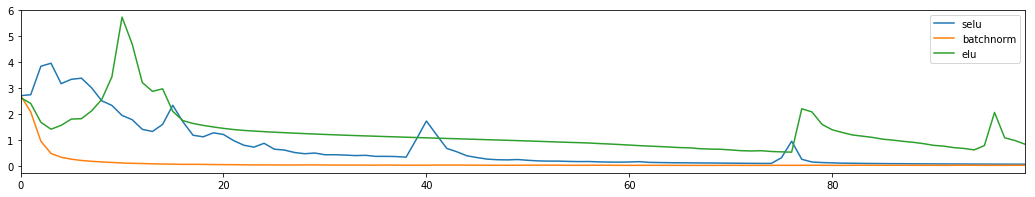

time: 160 ms


In [42]:
_ = pd.Series( h1.history[ 'loss' ], name='selu' ).plot.line( legend=True )
_ = pd.Series( h2.history[ 'loss' ], name='batchnorm' ).plot.line( legend=True )
_ = pd.Series( h3.history[ 'loss' ], name='elu' ).plot.line( legend=True )

# check

In [43]:
def np_selu( x ):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * np.where( x >= 0., x, alpha * np.exp( x ) - alpha )

time: 1.69 ms


In [44]:
t = train_x
print( t.shape )
for i in range( 20 ):
    w = np.random.normal( size=( train_x.shape[ 1 ], train_x.shape[ 1 ] ), scale=math.sqrt( 1. / train_x.shape[ 1 ] ) )
    t = np_selu( np.dot( t, w ) )
    print( '%r\t%r\t%r' % ( i, t.mean(), t.var() ) )

(60000, 784)
0	-0.011920605712988516	0.85198201477584057
1	-0.014009930001073685	0.84009209231053528
2	-0.014833814263369665	0.83710566498916028
3	-0.01345325858059928	0.85542114695937022
4	-0.011074051521657149	0.87604506129786197
5	-0.01538204698140253	0.88946831604468357
6	-0.012597512179082785	0.90667193212244246
7	-0.012218370386710061	0.92522697872572746
8	-0.011835921087635265	0.93761840394517637
9	-0.0074533372373455486	0.9401515317599346
10	-0.00042083918916277485	0.95321168773018539
11	-0.0031128792794270456	0.95115693334616513
12	-0.0060753594076044578	0.97491144573548649
13	-0.0025468591997165543	0.96868499301251776
14	-0.0026659201866568358	0.97255763241804294
15	0.0022811015280165795	0.98521077735463736
16	-0.0079720580471199128	0.98059247457471876
17	-0.0081024385035842091	0.98552152268067084
18	-0.0037256306834446804	0.98150133786185612
19	-0.0031892810750676062	0.98438915338626953
time: 50 s


In [45]:
t = np.random.normal( size=( train_x.shape[ 0 ], train_x.shape[ 1 ] ) )
for i in range( 20 ):
    w = np.random.normal( size=( train_x.shape[ 1 ], train_x.shape[ 1 ] ), scale=math.sqrt( 1. / train_x.shape[ 1 ] ) )
    t = np_selu( np.dot( t, w ) )
    print( '%r\t%r\t%r' % ( i, t.mean(), t.var() ) )

0	8.8917216914988876e-05	1.0016365283566371
1	0.00033826504362383558	1.0006840805694719
2	-0.00073038797663131693	0.99611003249518393
3	2.8628515289885415e-05	0.99952143589225884
4	0.00067301329832848927	1.0041382115652706
5	0.00078331525111077955	1.0052397062868257
6	-0.0003133192233469347	1.0021971331562054
7	0.00053718432781164937	1.0009316085610163
8	-0.00085682833216060221	1.0032191018325833
9	-0.00090194685470240969	0.99931213219912995
10	0.00016912271394340804	0.99536900337506862
11	-7.1582761479131846e-05	0.99922497792148435
12	-0.00091602064390040633	0.99455061991274651
13	0.00043653392394994863	0.99708407507611263
14	-0.0019440107130257829	1.0027700623031297
15	0.0023220144489770013	1.0052443198166001
16	-0.0007566922542048437	0.9940181188021181
17	0.00094569425123910652	0.99477900543532549
18	0.0020817759208735204	0.99422125598369582
19	0.00020090475405414455	0.99437475665605879
time: 52 s


In [46]:
t = np.random.normal( size=( 300, 200 ) )
for i in range( 20 ):
    w = np.random.normal( size=( 200, 200 ), scale=math.sqrt( 1. / 200 ) )
    t = np_selu( np.dot( t, w ) )
    print( '%r\t%r\t%r' % ( i, t.mean(), t.var() ) )

0	0.00061197383780942159	1.0049188121767569
1	-0.0021906774801428376	0.99610492452485344
2	-0.0026018570652697019	0.97297968057537476
3	-0.0059959469918653002	0.96624082882116791
4	-0.005262518223938556	0.97338897993584539
5	-0.0026770559077949649	0.96008053782939318
6	0.00017882479782118269	0.98618381145220491
7	-0.0039505649932618887	0.99606208374990979
8	-0.0049368025448500285	0.997437761323688
9	-0.010580089033221943	0.98464502152844147
10	-0.010901693856057262	0.96191131676100172
11	-0.0053341707440030537	0.9623296710077377
12	0.0013069063968984716	0.98583348302952467
13	0.010631826133720547	1.031277486012151
14	0.010889481582452286	1.0368072802776547
15	0.0053155587091486788	1.022010899532783
16	0.02259918219952391	1.032625511429478
17	-0.0019931906643187529	1.0200213627630039
18	-0.0013621488479305191	1.0017253033754758
19	0.0018963665556534855	0.99340757004512636
time: 130 ms
